<a href="https://colab.research.google.com/github/hannesstuehrenberg/Probabilistic-Machine-Learning_lecture-PROJECTS/blob/main/projects/08-1SHXXXX_football_analytics/notebooks/data_loading_and_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 2. Data Loading and Exploration

- Code to load data
- Basic exploration (plots, statistics, missing data, etc.)

In [2]:
pip install mplsoccer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 3.4 MB/s eta 0:00:00


In [3]:
# importing necessary libraries
import pandas as pd
import numpy as np
import json
# plotting
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch
# statistical fitting of models
#switch to scikitlearn
#import statsmodels.api as sm
#import statsmodels.formula.api as smf
#opening data
import os
import pathlib
import warnings


pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [4]:
from mplsoccer import Sbopen
parser = Sbopen()

In [5]:
df_competition = parser.competition()
df_competition.info()
df_competition.head(50)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   competition_id             74 non-null     int64 
 1   season_id                  74 non-null     int64 
 2   country_name               74 non-null     object
 3   competition_name           74 non-null     object
 4   competition_gender         74 non-null     object
 5   competition_youth          74 non-null     bool  
 6   competition_international  74 non-null     bool  
 7   season_name                74 non-null     object
 8   match_updated              74 non-null     object
 9   match_updated_360          56 non-null     object
 10  match_available_360        10 non-null     object
 11  match_available            74 non-null     object
dtypes: bool(2), int64(2), object(8)
memory usage: 6.1+ KB


,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,281,Germany,1. Bundesliga,male,False,False,2023/2024,2024-07-15T14:15:54.671676,2024-07-15T14:17:00.877356,2024-07-15T14:17:00.877356,2024-07-15T14:15:54.671676
1,9,27,Germany,1. Bundesliga,male,False,False,2015/2016,2024-05-19T11:11:14.192381,None,None,2024-05-19T11:11:14.192381
2,1267,107,Africa,African Cup of Nations,male,False,True,2023,2024-06-13T07:51:02.452825,None,None,2024-06-13T07:51:02.452825
3,16,4,Europe,Champions League,male,False,False,2018/2019,2024-06-12T07:44:38.559714,2021-06-13T16:17:31.694,None,2024-06-12T07:44:38.559714
4,16,1,Europe,Champions League,male,False,False,2017/2018,2024-02-13T02:35:28.134882,2021-06-13T16:17:31.694,None,2024-02-13T02:35:28.134882
5,16,2,Europe,Champions League,male,False,False,2016/2017,2024-02-13T02:37:32.205154,2021-06-13T16:17:31.694,None,2024-02-13T02:37:32.205154
6,16,27,Europe,Champions League,male,False,False,2015/2016,2024-06-12T07:45:38.786894,2021-06-13T16:17:31.694,None,2024-06-12T07:45:38.786894
7,16,26,Europe,Champions League,male,False,False,2014/2015,2024-02-12T12:49:54.914228,2021-06-13T16:17:31.694,None,2024-02-12T12:49:54.914228
8,16,25,Europe,Champions League,male,False,False,2013/2014,2024-02-12T12:48:48.479157,2021-06-13T16:17:31.694,None,2024-02-12T12:48:48.479157
9,16,24,Europe,Champions League,male,False,False,2012/2013,2024-02-12T12:47:34.340413,2021-06-13T16:17:31.694,None,2024-02-12T12:47:34.340413


In [6]:
# This loads all matches across competitions and seasons
all_matches = pd.DataFrame()
df_competition = parser.competition()

for _, row in df_competition.iterrows():
    try:
        matches = parser.match(row['competition_id'], row['season_id'])
        all_matches = pd.concat([all_matches, matches], ignore_index=True)
    except:
        continue  # Some competition-season pairs might be missing data


In [7]:
match_counts = all_matches.groupby('competition_name').size().sort_values(ascending=False)


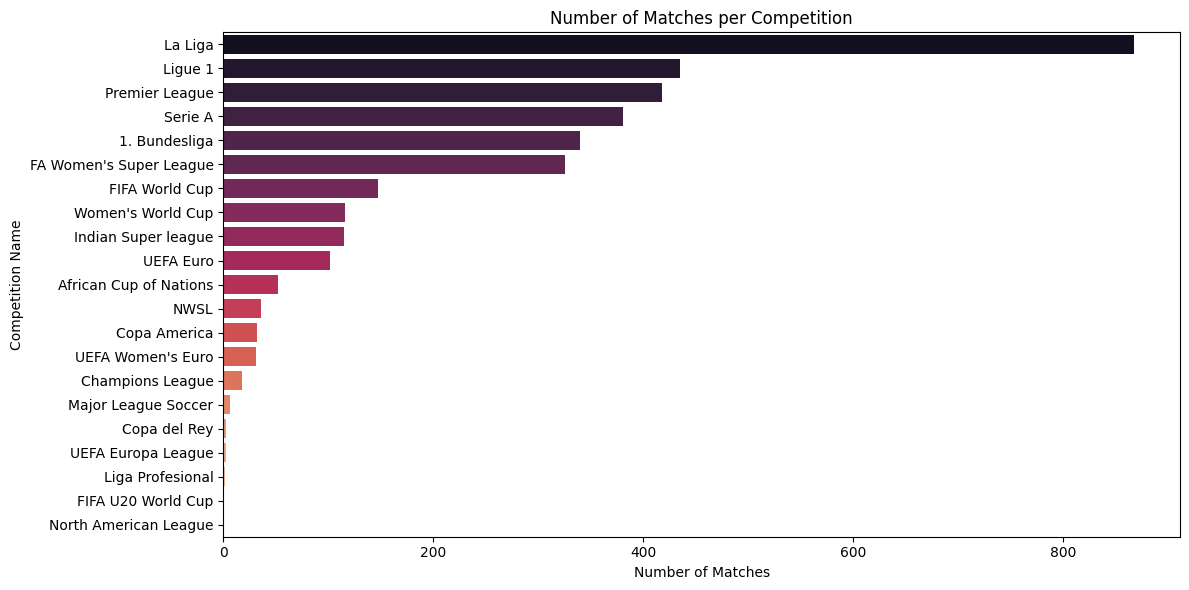

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x=match_counts.values, y=match_counts.index, palette="rocket")

plt.title('Number of Matches per Competition')
plt.xlabel('Number of Matches')
plt.ylabel('Competition Name')
plt.tight_layout()
plt.show()


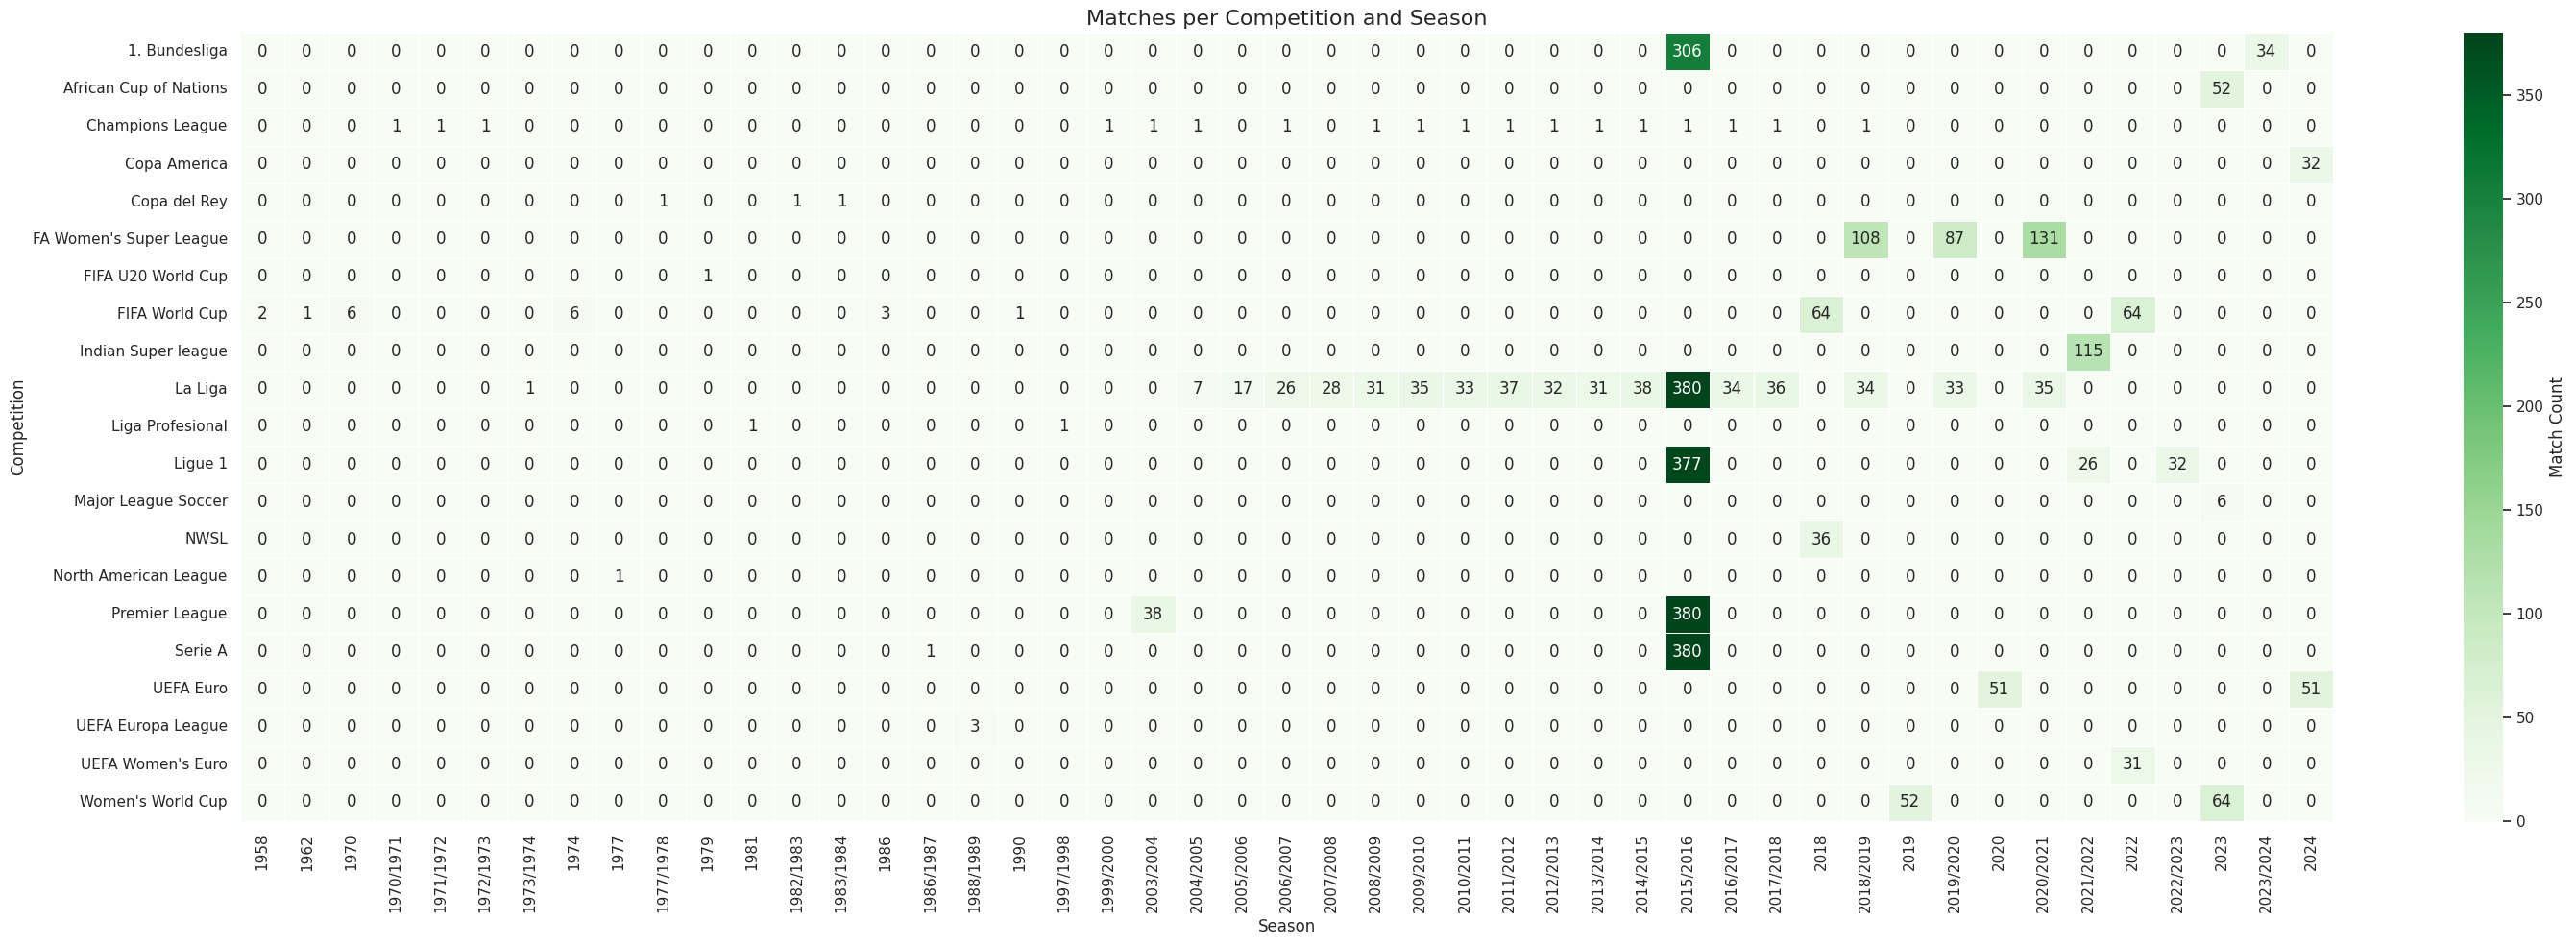

In [9]:
# Create a pivot table: rows = competition, columns = season, values = match count
pivot = all_matches.pivot_table(
    index='competition_name',
    columns='season_name',
    values='match_id',
    aggfunc='count',
    fill_value=0
)

# Remove total row and column before plotting
pivot_plot = pivot.drop(index='Total', errors='ignore') \
                              .drop(columns='Total', errors='ignore')


plt.figure(figsize=(30, 10))  # Increase width and height
sns.set(font_scale=1.0)       # Slightly bigger text, adjust if needed



# Plot heatmap without totals
ax = sns.heatmap(pivot_plot,
                 cmap = "Greens",
                 linewidths=0.5,
                 annot=True,
                 fmt='d',
                 cbar_kws={'label': 'Match Count'})

plt.title('Matches per Competition and Season', fontsize=16)
plt.xlabel('Season')
plt.ylabel('Competition')
plt.tight_layout()
plt.show()


In [10]:
df_event, df_related, df_freeze, df_tactics = parser.event(69301)
df_event['type_name'].value_counts()

,count
type_name,
Pass,921
Ball Receipt,832
Carry,765
Pressure,236
Ball Recovery,126
Duel,72
Clearance,57
Block,41
Dispossessed,35


In [11]:
shots_df = df_event[df_event["type_name"] == 'Shot']
shots_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19 entries, 339 to 3195
Data columns (total 73 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              19 non-null     object 
 1   index                           19 non-null     int64  
 2   period                          19 non-null     int64  
 3   timestamp                       19 non-null     object 
 4   minute                          19 non-null     int64  
 5   second                          19 non-null     int64  
 6   possession                      19 non-null     int64  
 7   duration                        19 non-null     float64
 8   match_id                        19 non-null     int64  
 9   type_id                         19 non-null     int64  
 10  type_name                       19 non-null     object 
 11  possession_team_id              19 non-null     int64  
 12  possession_team_name            19 non-

In [12]:
shots_df.head()

,id,index,period,timestamp,minute,second,possession,duration,match_id,type_id,...,dribble_overrun,block_deflection,bad_behaviour_card_id,bad_behaviour_card_name,pass_no_touch,block_save_block,foul_committed_advantage,foul_won_advantage,foul_committed_card_id,foul_committed_card_name
339,a425a1dc-0ce2-415e-bf03-55c6b95e794a,340,1,00:10:24.396000,10,24,18,1.342346,69301,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
530,29463e66-91b9-4d03-aae5-d40a35da078c,531,1,00:15:28.174000,15,28,25,0.472900,69301,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
719,cf531f3a-9c18-49b8-8cfd-7d04806033db,720,1,00:21:08.216000,21,8,35,1.254112,69301,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
741,4bb16d93-d6e4-4717-89b8-950b3dfbfa93,742,1,00:22:46.449000,22,46,37,1.118733,69301,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
955,820f6924-fa10-420d-81f7-f6a66d589edd,956,1,00:30:38.174000,30,38,52,1.359400,69301,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
shots = df_event[df_event['type_name'] == 'Shot']


shot_fields = [
    'id',
    'team_id',
    'team_name',
    'shot_key_pass_id',
    'x',
    'y',
    'end_x',
    'end_y',
    'end_z',
    'aerial_won',
    #'follows_dribble',
    'shot_first_time',
    #'freeze_frame',
    #'open_goal',
    'shot_statsbomb_xg',
    #'deflected',
    'block_deflection',    #is this column necessary?
    'technique_id',
    'technique_name',
    'body_part_id',
    'body_part_name',
    'sub_type_id',
    'sub_type_name',
    'outcome_id',
    'outcome_name'
]

shot_df_reduced = shots[shot_fields]
shot_df_reduced.head(50)

,id,team_id,team_name,shot_key_pass_id,x,y,end_x,end_y,end_z,aerial_won,...,shot_statsbomb_xg,block_deflection,technique_id,technique_name,body_part_id,body_part_name,sub_type_id,sub_type_name,outcome_id,outcome_name
339,a425a1dc-0ce2-415e-bf03-55c6b95e794a,858,Sweden Women's,NaN,104.7,45.5,120.0,43.6,0.2,NaN,...,0.105188,NaN,93.0,Normal,40.0,Right Foot,87.0,Open Play,97.0,Goal
530,29463e66-91b9-4d03-aae5-d40a35da078c,858,Sweden Women's,d965f959-89c6-4dba-8d96-0db33d767d5f,110.9,53.1,118.4,44.2,0.7,NaN,...,0.039004,NaN,93.0,Normal,38.0,Left Foot,87.0,Open Play,116.0,Saved to Post
719,cf531f3a-9c18-49b8-8cfd-7d04806033db,858,Sweden Women's,cfd65365-fe65-4f44-977b-35444b9f2016,107.8,26.1,120.0,43.9,1.0,NaN,...,0.035328,NaN,93.0,Normal,40.0,Right Foot,87.0,Open Play,97.0,Goal
741,4bb16d93-d6e4-4717-89b8-950b3dfbfa93,865,England Women's,NaN,93.7,51.1,118.8,43.9,0.4,NaN,...,0.018011,NaN,91.0,Half Volley,40.0,Right Foot,87.0,Open Play,100.0,Saved
955,820f6924-fa10-420d-81f7-f6a66d589edd,865,England Women's,101b0757-53cd-46e2-a8b0-b4c48fd84df2,108.0,52.7,120.0,36.1,0.3,NaN,...,0.100729,NaN,93.0,Normal,38.0,Left Foot,87.0,Open Play,97.0,Goal
1326,8a45dfd3-2310-48f6-89fe-8c5ae708a94a,858,Sweden Women's,NaN,83.6,47.1,117.5,42.8,0.5,NaN,...,0.006903,NaN,93.0,Normal,40.0,Right Foot,87.0,Open Play,100.0,Saved
1484,daabd728-fbb8-4c01-abd1-6989b78bc00f,858,Sweden Women's,NaN,105.4,25.5,120.0,41.1,4.6,NaN,...,0.124660,NaN,92.0,Lob,40.0,Right Foot,87.0,Open Play,98.0,Off T
1576,f736b03f-8586-4d14-8541-f291c034ef48,865,England Women's,b2612645-ff47-4aa5-a959-f35a0ed38d65,108.4,53.3,113.9,46.9,0.5,NaN,...,0.139090,NaN,93.0,Normal,40.0,Right Foot,87.0,Open Play,100.0,Saved
1781,4c2ba976-abfe-4968-891f-ff869407a670,865,England Women's,248ad161-183e-4493-8d4c-3a33cb7fdf7c,84.3,31.3,103.3,32.8,NaN,NaN,...,0.006838,NaN,93.0,Normal,38.0,Left Foot,87.0,Open Play,96.0,Blocked
1793,c20c4661-1578-4c5b-90cc-3f989bd881cb,865,England Women's,4ac8b335-6da2-4af5-ba3e-4624e10162cd,81.9,35.2,120.0,34.2,0.6,NaN,...,0.006616,NaN,93.0,Normal,40.0,Right Foot,87.0,Open Play,98.0,Off T


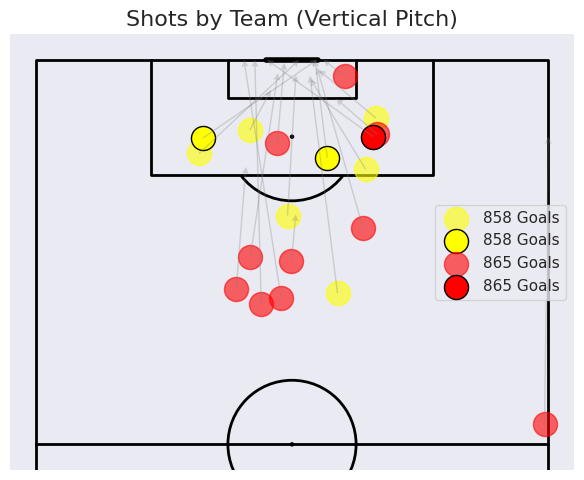

In [14]:
from mplsoccer import VerticalPitch
import matplotlib.pyplot as plt

# Set up vertical pitch
pitch = VerticalPitch(line_color='black', pitch_type='statsbomb', half=True)
fig, ax = pitch.draw(figsize=(6, 10))

# Define team colors by team_id
team_colors = {
    '858': 'yellow',
    '865': 'red'
}

# Plot shots per team
for team_id, color in team_colors.items():
    team_shots = shots_df[shots_df['team_id'].astype(str) == team_id]
    pitch.scatter(team_shots['x'], team_shots['y'], s=300, c=color, alpha=0.6, label=f'{team_id} Goals', ax=ax)

    # Highlight goals for this team
    team_goals = team_shots[team_shots['outcome_name'] == 'Goal']
    pitch.scatter(team_goals['x'], team_goals['y'], s=300, c=color, edgecolors='black', label=f'{team_id} Goals', ax=ax)

# Optional: Arrows to end location
pitch.arrows(shots_df['x'], shots_df['y'], shots_df['end_x'], shots_df['end_y'],
             width=1, headwidth=5, headlength=5, color='gray', alpha=0.3, ax=ax)

# Legend and title
ax.legend()
ax.set_title('Shots by Team (Vertical Pitch)', fontsize=16)
plt.show()


In [15]:
df_first_goal_freeze = df_freeze[df_freeze["id"] == 'a425a1dc-0ce2-415e-bf03-55c6b95e794a']
df_first_goal_freeze.info()
df_first_goal_freeze.head(13)

<class 'pandas.core.frame.DataFrame'>
Index: 14 entries, 0 to 13
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   teammate         14 non-null     bool   
 1   match_id         14 non-null     int64  
 2   id               14 non-null     object 
 3   x                14 non-null     float64
 4   y                14 non-null     float64
 5   player_id        14 non-null     int64  
 6   player_name      14 non-null     object 
 7   position_id      14 non-null     int64  
 8   position_name    14 non-null     object 
 9   event_freeze_id  14 non-null     int64  
dtypes: bool(1), float64(2), int64(4), object(3)
memory usage: 1.1+ KB


,teammate,match_id,id,x,y,player_id,player_name,position_id,position_name,event_freeze_id
0,True,69301,a425a1dc-0ce2-415e-bf03-55c6b95e794a,110.2,38.8,10229,Emma Stina Blackstenius,23,Center Forward,1
1,False,69301,a425a1dc-0ce2-415e-bf03-55c6b95e794a,94.0,24.7,10180,Ellen White,23,Center Forward,2
2,False,69301,a425a1dc-0ce2-415e-bf03-55c6b95e794a,100.2,36.4,4641,Francesca Kirby,15,Left Center Midfield,3
3,False,69301,a425a1dc-0ce2-415e-bf03-55c6b95e794a,101.9,45.3,15619,Bethany Mead,16,Left Midfield,4
4,True,69301,a425a1dc-0ce2-415e-bf03-55c6b95e794a,107.4,58.1,13881,Eva Sofia Jakobsson,17,Right Wing,5
5,False,69301,a425a1dc-0ce2-415e-bf03-55c6b95e794a,107.4,18.7,4654,Nikita Parris,12,Right Midfield,6
6,False,69301,a425a1dc-0ce2-415e-bf03-55c6b95e794a,101.5,27.6,10172,Jill Scott,13,Right Center Midfield,7
7,False,69301,a425a1dc-0ce2-415e-bf03-55c6b95e794a,107.1,26.0,10178,Lucy Bronze,2,Right Back,8
8,False,69301,a425a1dc-0ce2-415e-bf03-55c6b95e794a,118.7,42.7,19421,Carly Mitchell Telford,1,Goalkeeper,9
9,False,69301,a425a1dc-0ce2-415e-bf03-55c6b95e794a,113.1,45.5,10252,Alex Greenwood,6,Left Back,10


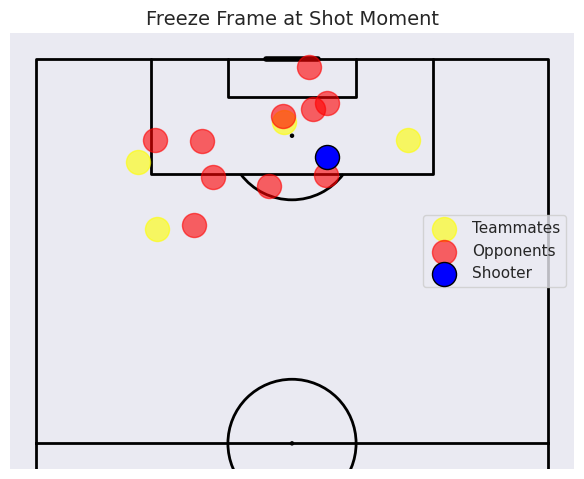

In [18]:
from mplsoccer import VerticalPitch
import matplotlib.pyplot as plt

pitch = VerticalPitch(pitch_type='statsbomb', half=True, line_color='black')
fig, ax = pitch.draw(figsize=(6, 10))

event_id = 'a425a1dc-0ce2-415e-bf03-55c6b95e794a'
freeze = df_first_goal_freeze

# Separate teammates and opponents
teammates = freeze[freeze['teammate'] == True]
opponents = freeze[freeze['teammate'] == False]

# Plot teammates in blue
pitch.scatter(teammates['x'], teammates['y'], s=300, c='yellow', alpha=0.6, label='Teammates', ax=ax)

# Plot opponents in red
pitch.scatter(opponents['x'], opponents['y'], s=300, c='red', alpha=0.6, label='Opponents', ax=ax)

# Highlight the shooter (assumes shooter is in teammates and has matching event ID)
shooter = shots_df[shots_df['id'] == event_id].iloc[0]
pitch.scatter(shooter['x'], shooter['y'], s=300, c='blue', edgecolors='black', label='Shooter', ax=ax)

# Title and legend
ax.set_title("Freeze Frame at Shot Moment", fontsize=14)
ax.legend(loc='right')
plt.show()


In [19]:
df_related[df_related["id"] == 'a425a1dc-0ce2-415e-bf03-55c6b95e794a']

,match_id,id,index,type_name,id_related,index_related,type_name_related
496,69301,a425a1dc-0ce2-415e-bf03-55c6b95e794a,340,Shot,e2c61b4a-f0eb-44f2-8899-df1778683ee9,341,Goal Keeper


In [20]:
matches_df = parser.match(competition_id=72, season_id=30)

match_ids = matches_df['match_id'].tolist()

shot_fields = [
    'id',
    'period',
    'timestamp',
    'play_pattern_id',
    'play_pattern_name',
    'team_id',
    'team_name',
    'player_id',
    'player_name',
    'body_part_id',
    'body_part_name',
    'shot_key_pass_id',
    'x',
    'y',
    'end_x',
    'end_y',
    'end_z',
    'aerial_won',
    'shot_first_time',
    'shot_statsbomb_xg',
    'block_deflection',
    'technique_id',
    'technique_name',
    'body_part_id',
    'body_part_name',
    'sub_type_id',
    'sub_type_name',
    'outcome_id',
    'outcome_name'
]

all_shots = []

for match_id in match_ids:
    df_event, df_related, df_freeze, df_tactics = parser.event(match_id)


    df_shots = df_event[df_event['type_name'] == 'Shot']

    for col in shot_fields:
        if col not in df_shots.columns:
            df_shots[col] = None

    # Keep only the desired fields
    df_shots_clean = df_shots[shot_fields].copy()
    df_shots_clean['match_id'] = match_id

    all_shots.append(df_shots_clean)

shots_master_women_world_cup_df = pd.concat(all_shots, ignore_index=True)


In [21]:
shots_master_women_world_cup_df.info()
shots_master_women_world_cup_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1314 entries, 0 to 1313
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1314 non-null   object 
 1   period             1314 non-null   int64  
 2   timestamp          1314 non-null   object 
 3   play_pattern_id    1314 non-null   int64  
 4   play_pattern_name  1314 non-null   object 
 5   team_id            1314 non-null   int64  
 6   team_name          1314 non-null   object 
 7   player_id          1314 non-null   float64
 8   player_name        1314 non-null   object 
 9   body_part_id       1314 non-null   float64
 10  body_part_name     1314 non-null   object 
 11  shot_key_pass_id   925 non-null    object 
 12  x                  1314 non-null   float64
 13  y                  1314 non-null   float64
 14  end_x              1314 non-null   float64
 15  end_y              1314 non-null   float64
 16  end_z              919 n

,id,period,timestamp,play_pattern_id,play_pattern_name,team_id,team_name,player_id,player_name,body_part_id,...,block_deflection,technique_id,technique_name,body_part_id,body_part_name,sub_type_id,sub_type_name,outcome_id,outcome_name,match_id
0,61ba8fdd-7b2e-4967-8c3c-038cad3d44c1,1,00:01:45.395000,3,From Free Kick,857,Germany Women's,10263.0,Sara Däbritz,38.0,...,NaN,93.0,Normal,38.0,Left Foot,62.0,Free Kick,96.0,Blocked,22949
1,3473cc2a-c7b4-4c21-b4c5-3631b79d8ba8,1,00:13:55.191000,4,From Throw In,863,Spain Women's,25510.0,Nahikari García Pérez,40.0,...,NaN,93.0,Normal,40.0,Right Foot,87.0,Open Play,98.0,Off T,22949
2,b987d5a3-0152-4919-8fcf-5ad26f4b2883,1,00:15:47.927000,4,From Throw In,863,Spain Women's,10153.0,Silvia Meseguer Bellido,40.0,...,NaN,93.0,Normal,40.0,Right Foot,87.0,Open Play,98.0,Off T,22949
3,cd838028-9847-4638-86d6-955feb6ec3e0,1,00:16:44.355000,1,Regular Play,857,Germany Women's,25492.0,Giulia Gwinn,40.0,...,NaN,93.0,Normal,40.0,Right Foot,87.0,Open Play,100.0,Saved,22949
4,7d9bced3-546a-4116-aded-67eeed94a1f5,1,00:17:46.017000,1,Regular Play,857,Germany Women's,25492.0,Giulia Gwinn,40.0,...,NaN,93.0,Normal,40.0,Right Foot,87.0,Open Play,98.0,Off T,22949


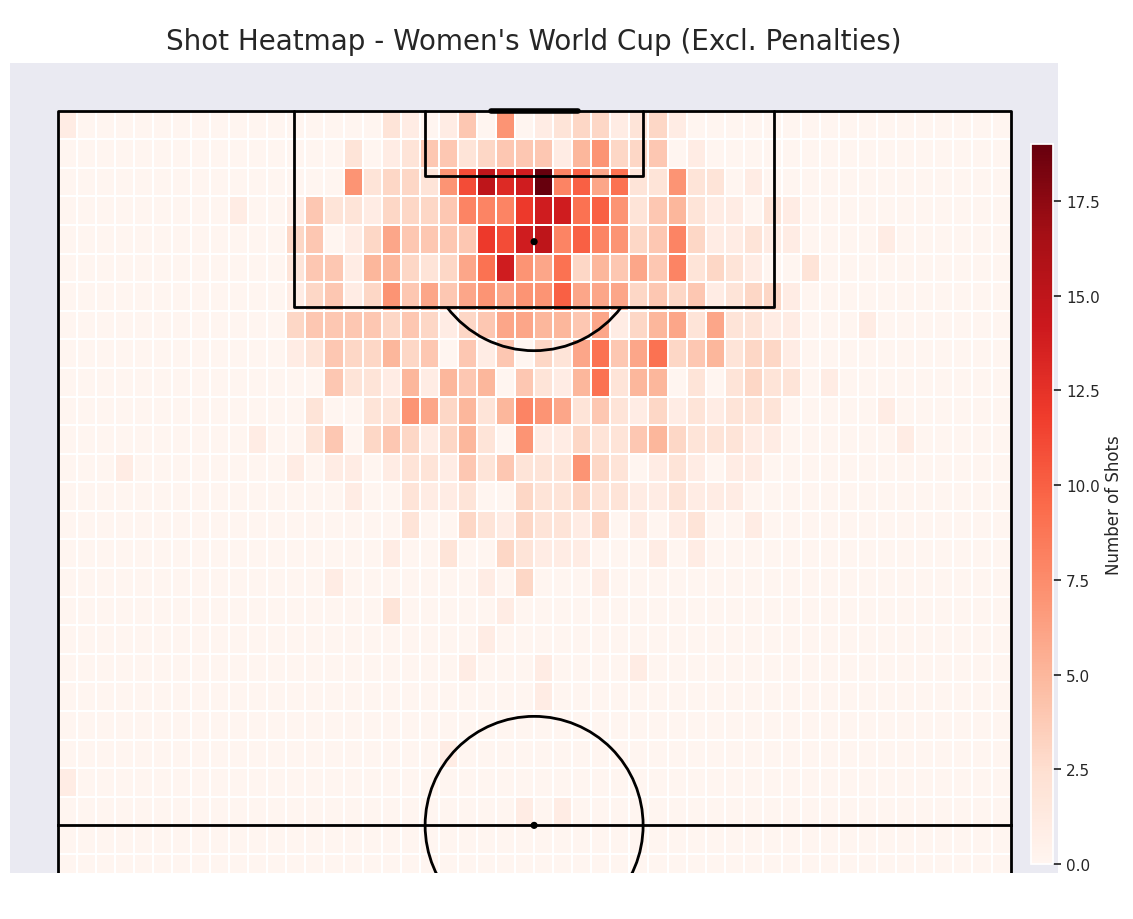

In [22]:
# Filter out penalties
shots_no_penalties = shots_master_women_world_cup_df[shots_master_women_world_cup_df['sub_type_name'] != 'Penalty']

# Set up the pitch
pitch = VerticalPitch(
    line_color='black',
    half=True,
    pitch_type='custom',
    pitch_length=120,
    pitch_width=80,
    line_zorder=2
)

fig, ax = pitch.grid(
    grid_height=0.9,
    title_height=0.06,
    axis=False,
    endnote_height=0.04,
    title_space=0,
    endnote_space=0
)

# Calculate bin statistics without penalties
bin_statistic_shots = pitch.bin_statistic(
    shots_no_penalties['x'],
    shots_no_penalties['y'],
    bins=(50, 50)
)

# Plot heatmap
pcm = pitch.heatmap(
    bin_statistic_shots,
    ax=ax['pitch'],
    cmap='Reds',
    edgecolor='white',
    linewidth=0.01
)

# Colorbar
ax_cbar = fig.add_axes((0.95, 0.05, 0.02, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
cbar.set_label('Number of Shots')

# Title
fig.suptitle('Shot Heatmap - Women\'s World Cup (Excl. Penalties)', fontsize=20)
plt.show()


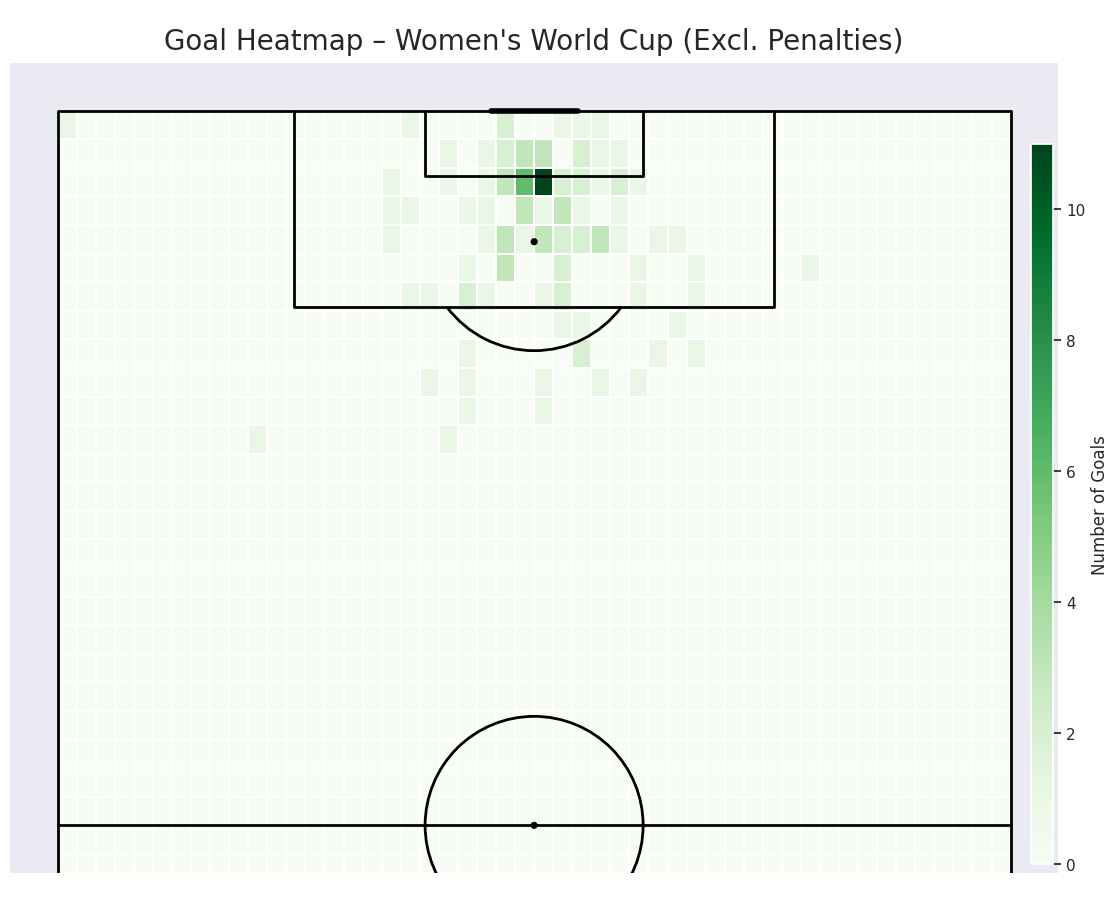

In [23]:
non_penalty_shots = shots_master_women_world_cup_df[shots_master_women_world_cup_df['sub_type_name'] != 'Penalty']

goals = non_penalty_shots[non_penalty_shots['outcome_name'] == 'Goal']

from mplsoccer import VerticalPitch
import matplotlib.pyplot as plt

# Set up pitch
pitch = VerticalPitch(
    line_color='black',
    half=True,
    pitch_type='custom',
    pitch_length=120,
    pitch_width=80,
    line_zorder=2
)

fig, ax = pitch.grid(
    grid_height=0.9,
    title_height=0.06,
    axis=False,
    endnote_height=0.04,
    title_space=0,
    endnote_space=0
)

# Compute bin stats for goals only
bin_statistic_goals = pitch.bin_statistic(
    goals['x'],
    goals['y'],
    bins=(50, 50)
)

# Heatmap
pcm = pitch.heatmap(
    bin_statistic_goals,
    ax=ax['pitch'],
    cmap='Greens',
    edgecolor='white',
    linewidth=0.01
)

# Colorbar
ax_cbar = fig.add_axes((0.95, 0.05, 0.02, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
cbar.set_label('Number of Goals')

# Title
fig.suptitle('Goal Heatmap – Women\'s World Cup (Excl. Penalties)', fontsize=20)
plt.show()



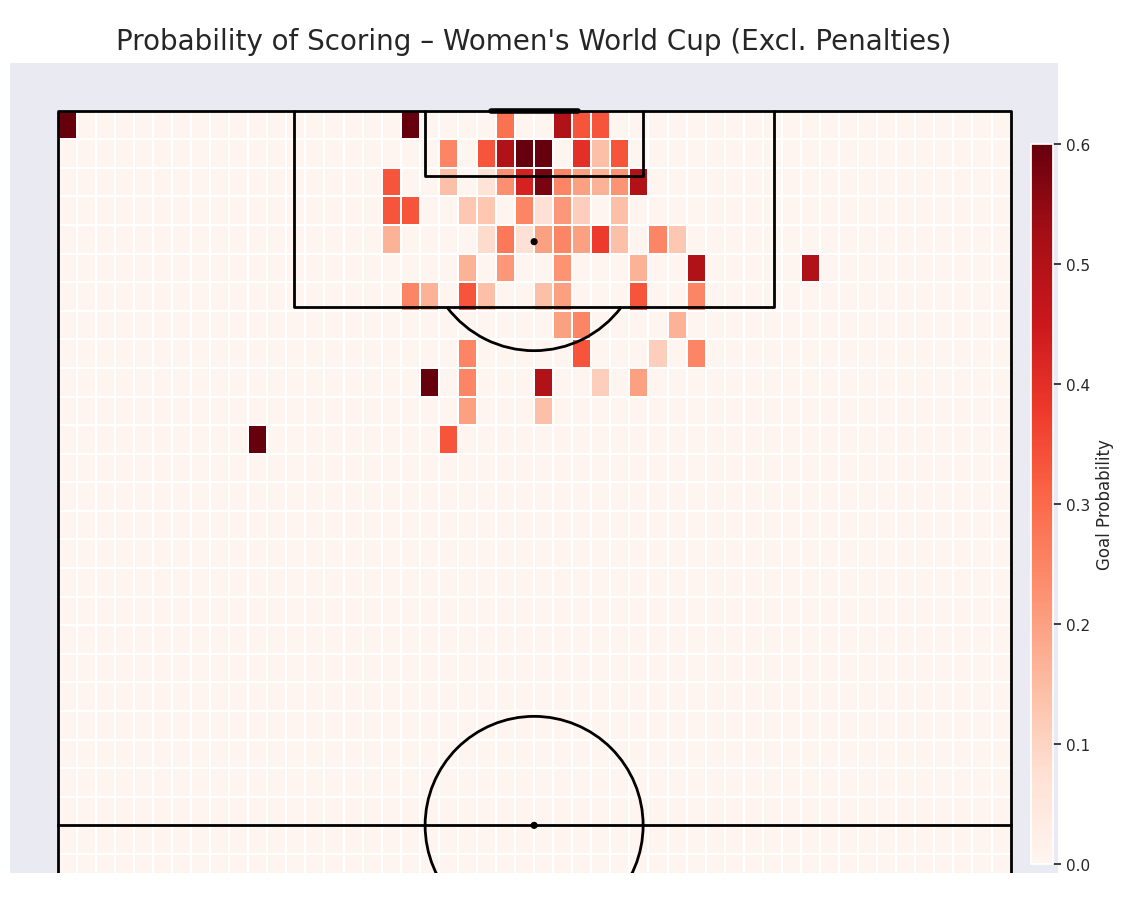

In [24]:
from mplsoccer import VerticalPitch
import matplotlib.pyplot as plt

# 1. Filter out penalties
non_penalty_shots = shots_master_women_world_cup_df[shots_master_women_world_cup_df['sub_type_name'] != 'Penalty']

# 2. Separate all shots and goals
shots = non_penalty_shots
goals = shots[shots['outcome_name'] == 'Goal']

# 3. Create the pitch
pitch = VerticalPitch(
    line_color='black',
    half=True,
    pitch_type='custom',
    pitch_length=120,  # adjust if your x values go to 120
    pitch_width=80,    # adjust if your y values go to 80
    line_zorder=2
)

fig, ax = pitch.grid(
    grid_height=0.9,
    title_height=0.06,
    axis=False,
    endnote_height=0.04,
    title_space=0,
    endnote_space=0
)

# 4. Bin stats
bin_shots = pitch.bin_statistic(shots['x'], shots['y'], bins=(50, 50))
bin_goals = pitch.bin_statistic(goals['x'], goals['y'], bins=(50, 50))

# 5. Calculate goal probability (clip to avoid division by zero)
goal_probability = bin_goals['statistic'] / bin_shots['statistic']
goal_probability = np.nan_to_num(goal_probability, nan=0.0, posinf=0.0, neginf=0.0)
bin_shots['statistic'] = goal_probability

# 6. Plot heatmap
pcm = pitch.heatmap(
    bin_shots,
    ax=ax['pitch'],
    cmap='Reds',
    edgecolor='white',
    vmin=0,
    vmax=0.6,
    linewidth=0.01
)

# 7. Colorbar
ax_cbar = fig.add_axes((0.95, 0.05, 0.02, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
cbar.set_label('Goal Probability')

# 8. Title
fig.suptitle('Probability of Scoring – Women\'s World Cup (Excl. Penalties)', fontsize=20)
plt.show()


In [86]:
import numpy as np

shots_master_women_world_cup_df['distance_to_goal'] = np.sqrt(
    (GOAL_X - shots_master_women_world_cup_df['x'])**2 +
    (GOAL_CENTER_Y - shots_master_women_world_cup_df['y'])**2
)

In [99]:
import numpy as np

# Constants
GOAL_WIDTH = 7.32  # meters
GOAL_CENTER_X = 120
GOAL_CENTER_Y = 40

In [100]:
distance_to_goal = np.sqrt((GOAL_CENTER_X - x)**2 + (GOAL_CENTER_Y - y)**2)
shots_master_women_world_cup_df['distance_to_goal'] = distance_to_goal

In [101]:
# Goalpost y-coordinates
goal_y1 = GOAL_CENTER_Y - GOAL_WIDTH / 2  # left post
goal_y2 = GOAL_CENTER_Y + GOAL_WIDTH / 2  # right post

# Shot coordinates
x = shots_master_women_world_cup_df['x'].to_numpy()
y = shots_master_women_world_cup_df['y'].to_numpy()

# Distances from shot to left and right goalposts
a = np.sqrt((GOAL_CENTER_X - x)**2 + (goal_y1 - y)**2)
b = np.sqrt((GOAL_CENTER_X - x)**2 + (goal_y2 - y)**2)
c = GOAL_WIDTH

# Avoid divide-by-zero
denominator = 2 * a * b
cos_angle = (a**2 + b**2 - c**2) / denominator
cos_angle = np.clip(cos_angle, -1.0, 1.0)  # Ensure within valid arccos range

# Calculate angle in radians
angle_radians = np.arccos(cos_angle)

# Store in DataFrame
shots_master_women_world_cup_df['angle_to_goal'] = angle_radians
shots_master_women_world_cup_df['angle_to_goal_deg'] = np.degrees(angle_radians)


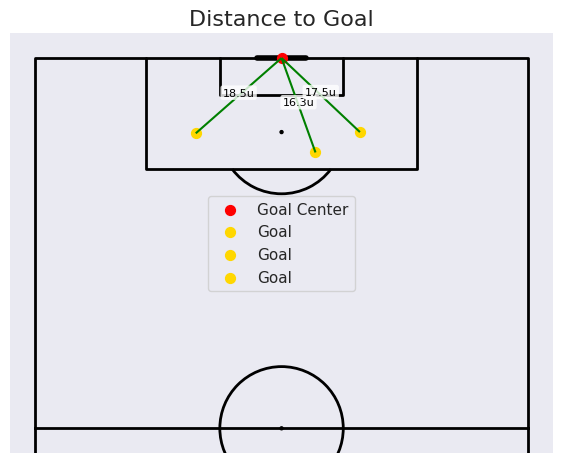

In [103]:
from mplsoccer import VerticalPitch
import matplotlib.pyplot as plt

test_plot = shots_master_women_world_cup_df[['id','period', 'timestamp', 'team_id', 'team_name', 'player_id', 'player_name', 'x', 'y', 'distance_to_goal', 'angle_to_goal', 'angle_to_goal_deg', 'match_id', 'outcome_name']]

goals_df = test_plot[
    (test_plot['match_id'] == 69301) &
    (test_plot['outcome_name'] == 'Goal')
]


##############################

goal_x = 120
goal_y = 40

# Create the pitch
pitch = VerticalPitch(pitch_type='statsbomb', line_color='black', half = True)
fig, ax = pitch.draw(
    #figsize=(6, 10)
    )

pitch.scatter(goal_x, goal_y, s=50, c='red', ax=ax, label='Goal Center')

for _, row in goals_df.iterrows():
    shot_x = row['x']
    shot_y = row['y']
    distance = row['distance_to_goal']

    # Shot location
    pitch.scatter(shot_x, shot_y, ax=ax, c='gold', s=50, label='Goal')

    # Line to goal center
    pitch.lines(shot_x, shot_y, goal_x, goal_y, ax=ax, color='green', lw=1.5)

    mid_x = (shot_x + goal_x) / 2
    mid_y = (shot_y + goal_y) / 2
    pitch.annotate(
      f"{distance:.1f}u",
      xy=(mid_x, mid_y),
      ax=ax,
      fontsize=8,
      ha='center',
      color='black',
      bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round', pad=0.2)
    )



# Title and legend
ax.set_title('Distance to Goal', fontsize=16)
ax.legend()
plt.show()

In [93]:
goal_width = 7.32
left_post_y = goal_y - goal_width / 2
right_post_y = goal_y + goal_width / 2

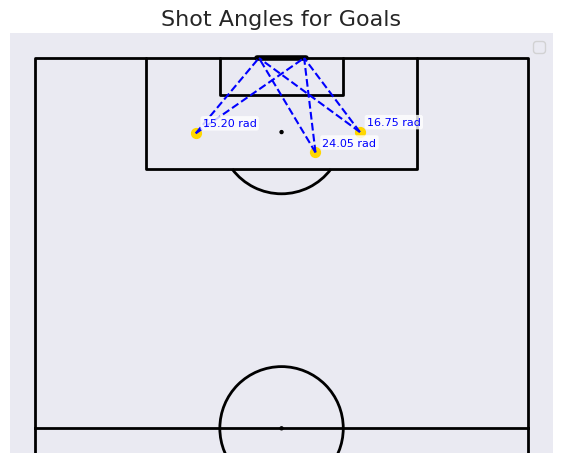

In [95]:
from mplsoccer import VerticalPitch
import matplotlib.pyplot as plt

goal_x, goal_y = 120, 40
goal_width = 7.32
left_post_y = goal_y - goal_width / 2
right_post_y = goal_y + goal_width / 2

pitch = VerticalPitch(pitch_type='statsbomb', line_color='black', half=True)
fig, ax = pitch.draw()

for i, row in goals_df.iterrows():
    shot_x = row['x']
    shot_y = row['y']
    angle = row['angle_to_goal_deg']

    pitch.scatter(shot_x, shot_y, ax=ax, c='gold', s=50, label='Goal' if i == 0 else None)

    pitch.lines(shot_x, shot_y, goal_x, left_post_y, ax=ax, color='blue', lw=1.5, linestyle='--')
    pitch.lines(shot_x, shot_y, goal_x, right_post_y, ax=ax, color='blue', lw=1.5, linestyle='--')

    pitch.annotate(
        f"{angle:.2f} rad",
        xy=(shot_x, shot_y),
        ax=ax,
        fontsize=8,
        ha='left',
        color='blue',
        xytext=(5, 5),
        textcoords='offset points',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round' ,pad=0.2)
    )

ax.set_title('Shot Angles for Goals', fontsize=16)
ax.legend()
plt.show()

In [96]:
goals_df.info()
goals_df.head(20)

<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, 468 to 472
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 3 non-null      object 
 1   period             3 non-null      int64  
 2   timestamp          3 non-null      object 
 3   team_id            3 non-null      int64  
 4   team_name          3 non-null      object 
 5   player_id          3 non-null      float64
 6   player_name        3 non-null      object 
 7   x                  3 non-null      float64
 8   y                  3 non-null      float64
 9   distance_to_goal   3 non-null      float64
 10  angle_to_goal      3 non-null      float64
 11  angle_to_goal_deg  3 non-null      float64
 12  match_id           3 non-null      int64  
 13  outcome_name       3 non-null      object 
dtypes: float64(6), int64(3), object(5)
memory usage: 360.0+ bytes


,id,period,timestamp,team_id,team_name,player_id,player_name,x,y,distance_to_goal,angle_to_goal,angle_to_goal_deg,match_id,outcome_name
468,a425a1dc-0ce2-415e-bf03-55c6b95e794a,1,00:10:24.396000,858,Sweden Women's,10220.0,Kosovare Asllani,104.7,45.5,16.258536,0.419771,24.051114,69301,Goal
470,cf531f3a-9c18-49b8-8cfd-7d04806033db,1,00:21:08.216000,858,Sweden Women's,13881.0,Eva Sofia Jakobsson,107.8,26.1,18.494594,0.265320,15.201717,69301,Goal
472,820f6924-fa10-420d-81f7-f6a66d589edd,1,00:30:38.174000,865,England Women's,4641.0,Francesca Kirby,108.0,52.7,17.472550,0.292310,16.748156,69301,Goal


build database

In [122]:
# Step 1: Get all available competitions
competitions_df = parser.competition()

# Step 2: Prepare storage
all_shots = []

# Step 3: Define your desired shot fields
shot_fields = [
    'id',
    'team_id',
    'team_name',
    'shot_key_pass_id',
    'x',
    'y',
    'end_x',
    'end_y',
    'end_z',
    'aerial_won',
    'shot_first_time',
    'shot_statsbomb_xg',
    'block_deflection',
    'technique_id',
    'technique_name',
    'body_part_id',
    'body_part_name',
    'sub_type_id',
    'sub_type_name',
    'outcome_id',
    'outcome_name'
]

# Step 4: Loop through competitions and matches
for _, comp_row in competitions_df.iterrows():
    comp_id = comp_row['competition_id']
    season_id = comp_row['season_id']

    try:
        matches_df = parser.match(competition_id=comp_id, season_id=season_id)
    except Exception as e:
        print(f"Skipping competition {comp_id}-{season_id} due to error: {e}")
        continue

    for match_id in matches_df['match_id']:
        try:
            df_event, df_related, df_freeze, df_tactics = parser.event(match_id)
            df_shots = df_event[df_event['type_name'] == 'Shot']

            for col in shot_fields:
                if col not in df_shots.columns:
                    df_shots[col] = None

            df_shots_clean = df_shots[shot_fields].copy()
            df_shots_clean['match_id'] = match_id
            df_shots_clean['competition_id'] = comp_id
            df_shots_clean['season_id'] = season_id

            all_shots.append(df_shots_clean)

        except Exception as e:
            print(f"Error processing match {match_id}: {e}")
            continue


shots_master_df = pd.concat(all_shots, ignore_index=True)


KeyboardInterrupt: 